### This file contains the code to compute the similarity metric between an original file and its variants. It is parametrized by whether the file should be read as instructions or bytes.

Some earier file has the code to compute similarity between variants and plot this against effectiveness to prevent attacks

In [19]:
from scipy.stats import spearmanr, stats
from scipy.spatial.distance import euclidean
from random import randint, shuffle,sample,random
from os import listdir
from os.path import isfile, join
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline
path='/Users/fesponda/research/Diversity/Data/probNog_probBilr_randomized_2/'

ORIGINAL_FILE=path+'original'
TRANSFORMATION_INTENSITY_FILE='percent_bytes_moved'
OUTPUT_GRAPH='probNog_probBilr_randomized_2.pdf'

###Variable that controls if data is treated as bytes or instructions
BYTE_FILE=True
if BYTE_FILE:
    TRANSFORMS_DIR=path+'binaries/'
else:
    TRANSFORMS_DIR=path+'instructions/'


# Function Definitions

In [2]:
def read_instructions(file1):
    f=open(file1, 'r')
    P1=[]
    for line in f:
        P1.append(line.strip().replace(" ",""))
    return P1



In [3]:
def read_ELF(file1):
    with open(file1, 'rb') as f:
        P1=list(f.read())
    return P1



In [4]:
#P1=read_instructions(ORIGINAL_FILE)


In [5]:
def read_instructions_only_inst(file1):
    f=open(file1, 'r')
    P1=[]
    for line in f:
        P1.append(line.split()[0])
    return P1


In [6]:
def read_file(file1,BYTE_FILE):
    if BYTE_FILE: 
        return read_ELF(file1)
    else:
        return read_instructions(file1)

In [7]:
##Create dictionary. For each byte in the block we create unique entry. If a byte is repeated we append if its the first, second, etc occurrence
def P1_dictionary(P1):
    P1_dict={}
    P1_occ={}
    for index,byte in enumerate(P1):   
        if byte  in P1_occ.keys():
            P1_occ[byte]+=1
        else:
            P1_occ[byte]=1
        value=str(byte)+'_'+str(P1_occ[byte]) ## here we create a unique value for each byte in the section
        P1_dict[value]=index+1 #we start to count at 1
    return P1_dict

In [8]:
####Rank instructions of a block according to first file template
def rank_P2(P1_dict,P2,intersection=False):
    a=[]        
    b=[]
    med_rank=len(P1_dict.keys())/2.0
    P2_dict={}
    P2_occ={}
    for index,byte in enumerate(P2):   
        if byte  in P2_occ.keys():
            P2_occ[byte]+=1
        else:
            P2_occ[byte]=1
        value=str(byte)+'_'+str(P2_occ[byte]) ## here we create a unique value for each byte in the section
        if value in P1_dict.keys():
            P2_dict[value]=P1_dict[value]
            a.append(index+1)
            b.append(P2_dict[value])
        elif not intersection:
            P2_dict[value]=0 ###zero for no existent value....check Maybe not bother, Maybe random, maybe average
            P2_dict[value]=med_rank 
            #P2_dict[value]=randint(1,90)
            a.append(index+1)
            b.append(P2_dict[value])
            
    #print(len(a),len(b))
    return a,b



# Execution

In [9]:
# Get list of files
l = [f for f in listdir(TRANSFORMS_DIR) if isfile(join(TRANSFORMS_DIR, f)) and f[0]!='.']

In [10]:
# Compute similarity between original and each transform
P1=read_file(ORIGINAL_FILE,BYTE_FILE)
P1_dict=P1_dictionary(P1)
result=[]
for knob in l:
    P2=read_file(TRANSFORMS_DIR+knob,BYTE_FILE)
    a,b=rank_P2(P1_dict,P2,intersection=True)
    corr,p=spearmanr(a,b)
    result.append((knob,corr,p))
#print(result)

In [11]:
# Compute similarity between original and each transform
############################################Chunk version
'''
CHUNK_PERC=0.3
P1=read_file(ORIGINAL_FILE,BYTE_FILE)
chunk_size=int(CHUNK_PERC*len(P1)+1)


    
result=[]
for knob in l:

    suma=0
    i=0
    P2=read_file(TRANSFORMS_DIR+knob,BYTE_FILE)
    chunk_size2=int(CHUNK_PERC*len(P2)+1)
    used_chunks=[]
    for c_size in range(0,len(P1),chunk_size):
        P1_dict=P1_dictionary(P1[c_size:c_size+chunk_size])
        max_sim=0
        p=1
        current_chunk=-1
        for c_size2 in range(0,len(P2),chunk_size2):
            if c_size in used_chunks:
                continue
            a,b=rank_P2(P1_dict,P2[c_size2:c_size2+chunk_size2],intersection=True)
            corr,p=spearmanr(a,b)
            #print(corr)
            if corr > max_sim: 
                current_chunk=c_size2
                max_sim=corr
                p=p  
        #print('out')
        used_chunks.append(current_chunk)
        suma=suma+max_sim
        i+=1
        
    result.append((knob,suma/i,'nada'))
    
#print(result)
'''

"\nCHUNK_PERC=0.3\nP1=read_file(ORIGINAL_FILE,BYTE_FILE)\nchunk_size=int(CHUNK_PERC*len(P1)+1)\n\n\n    \nresult=[]\nfor knob in l:\n\n    suma=0\n    i=0\n    P2=read_file(TRANSFORMS_DIR+knob,BYTE_FILE)\n    chunk_size2=int(CHUNK_PERC*len(P2)+1)\n    used_chunks=[]\n    for c_size in range(0,len(P1),chunk_size):\n        P1_dict=P1_dictionary(P1[c_size:c_size+chunk_size])\n        max_sim=0\n        p=1\n        current_chunk=-1\n        for c_size2 in range(0,len(P2),chunk_size2):\n            if c_size in used_chunks:\n                continue\n            a,b=rank_P2(P1_dict,P2[c_size2:c_size2+chunk_size2],intersection=True)\n            corr,p=spearmanr(a,b)\n            #print(corr)\n            if corr > max_sim: \n                current_chunk=c_size2\n                max_sim=corr\n                p=p  \n        #print('out')\n        used_chunks.append(current_chunk)\n        suma=suma+max_sim\n        i+=1\n        \n    result.append((knob,suma/i,'nada'))\n    \n#print(resul

In [12]:
# Pair up the similarity with the intensity of the transform. This is very specific to the current file 
# formats. The intensity file has a fragment of the transforms file name and the intensity comma separated

result=sorted(result,key=lambda x: x[0])
with open(path+TRANSFORMATION_INTENSITY_FILE) as fp:
    lines=fp.readlines()

perc_moved=[]
for line in lines:
    l=line.rstrip().split(',')
    perc_moved.append((l[0],float(l[1])))
perc_moved=sorted(perc_moved,key=lambda x: x[0])
###check could of sorted but I rather check

simi=[]
move=[]

for sim in result:
    for perc in perc_moved:
        if perc[0] in sim[0]:
            print (perc[0], sim[0],sim[1],perc[1])
            simi.append(sim[1])
            move.append(perc[1])
            break
final=zip(result,perc_moved)

1000_0 httpd-1000_0 0.8262410018176888 25.9
1000_1 httpd-1000_1 0.8252374946405677 25.9
1000_2 httpd-1000_2 0.8455415196248505 22.8
1100_0 httpd-1100_0 0.8261513053627676 25.9
1100_1 httpd-1100_1 0.8267735422279469 25.9
1100_2 httpd-1100_2 0.8580622443502293 16.2
1200_0 httpd-1200_0 0.8708008040806705 10.4
1200_1 httpd-1200_1 0.834984516265617 20.9
1200_2 httpd-1200_2 0.8637135882536592 13.8
1300_0 httpd-1300_0 0.8356004907838182 23.5
1300_1 httpd-1300_1 0.7981888388222347 26.6
1300_2 httpd-1300_2 0.7981185589076162 26.6
1400_0 httpd-1400_0 0.8845785704258529 17.2
1400_1 httpd-1400_1 0.8965941612797843 14.5
1400_2 httpd-1400_2 0.8958454362854362 14.5
1500_0 httpd-1500_0 0.8302929589642741 25.4
1500_1 httpd-1500_1 0.8419493645901496 21.5
1500_2 httpd-1500_2 0.7673648950123467 32.7
1600_0 httpd-1600_0 0.8619433910199029 14.1
1600_1 httpd-1600_1 0.8630935678244706 14.1
1600_2 httpd-1600_2 0.8275962500215961 22.2
1700_0 httpd-1700_0 0.7662099554610806 32.7
1700_1 httpd-1700_1 0.82028874179

In [13]:
print(len(move),len(simi))

48 48


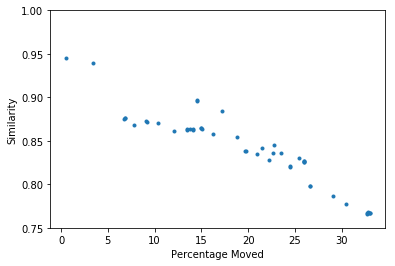

In [14]:
plt.scatter(move,simi,marker='.')
plt.ylabel('Similarity')
plt.xlabel('Percentage Moved')
plt.ylim([0.75, 1])
plt.savefig(OUTPUT_GRAPH)

In [15]:
s=zip(move,simi)
list(s)

[(25.9, 0.8262410018176888),
 (25.9, 0.8252374946405677),
 (22.8, 0.8455415196248505),
 (25.9, 0.8261513053627676),
 (25.9, 0.8267735422279469),
 (16.2, 0.8580622443502293),
 (10.4, 0.8708008040806705),
 (20.9, 0.834984516265617),
 (13.8, 0.8637135882536592),
 (23.5, 0.8356004907838182),
 (26.6, 0.7981888388222347),
 (26.6, 0.7981185589076162),
 (17.2, 0.8845785704258529),
 (14.5, 0.8965941612797843),
 (14.5, 0.8958454362854362),
 (25.4, 0.8302929589642741),
 (21.5, 0.8419493645901496),
 (32.7, 0.7673648950123467),
 (14.1, 0.8619433910199029),
 (14.1, 0.8630935678244706),
 (22.2, 0.8275962500215961),
 (32.7, 0.7662099554610806),
 (24.5, 0.8202887417939958),
 (24.5, 0.821511587593175),
 (32.9, 0.7669186965987448),
 (32.8, 0.7679202597739322),
 (12.1, 0.8609969131909516),
 (22.6, 0.8354500603755096),
 (13.5, 0.8631251058199246),
 (13.5, 0.8619625203439268),
 (33.0, 0.766566210754673),
 (30.4, 0.7771525920342606),
 (33.0, 0.7664626204098913),
 (6.8, 0.8757304947749054),
 (6.8, 0.876519131

In [16]:
print(len(set(P1).intersection(set(P2))),len(set(P1)),len(set(P2)))

256 256 256


In [17]:
print(len(P2),len(set(P2)),len(set(P2))/len(P2))

2297887 256 0.00011140669667394436


In [18]:
set(P1).intersection(set(P2))

{0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,
